In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymoo

# pymoo sub sections
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.operators.mixed_variable_operator import MixedVariableSampling, MixedVariableMutation, MixedVariableCrossover
from pymoo.optimize import minimize

# Utiliies for working with linkages (DeCoDE Lab)
from linkage_utils import *

# Other modules
import json
from IPython.display import HTML
import matplotlib.animation as animation
from tqdm.autonotebook import trange
import pickle

#set random seed for repeatability
np.random.seed(5)

## Linkage Synthesis Challenge Problem

This challenge problem is focused on synthesizing planar linkage mechanisms such that a specific output curve is traced using the mechanism. For this project you are tasked with synthesizing linkage mechanisms to trace 20 different output shapes. Further you are tasked with synthesizing mechanisms such that the total material used for the mechanisms in minimized. 

### Overview
The first portion of this notebook will help you understand the linkage design problem and the way we parameterize each linkage design. In the second half of this notebook we provide you with a working implementation that you can use as a baseline. We also provide numerous helper functions in the linkage_utils. We will explain what these functions do and how to use them throughout this notebook. 

### Mechanism Representation

For this project we expect you to represent planar mechanisms using the following components:
<ol>
    <li><b>Adjacency/Connectivity Matrix: </b>A linkage mechanisms structure can be represented using a matrix of connectivity (C), which is similar to the adjacency matrix in graphs. The connectivity matrix for a mechanisms with $N$ nodes is a symmetric $N\times N$ matrix with each row and column representing each node and its connections to other nodes. Take the example below:

<img src="https://i2.wp.com/transportgeography.org/wp-content/uploads/connectivity_matrix.png?resize=850%2C348&ssl=1" alt="Connectivity Matrix">

For Node A we use the first row/column of the matrix and we see that A is connected to B (which is represented by the second row/column). To represent this connection in the connectivity matrix we will set the value of the $(1,2)$ and $(2,1)$ elements of the matrix to be 1. Similarly any time any nodes $i$ and $j$ are connected we set the value of the $(i,j)$ and $(j,i)$ elements to be 1 and 0 if the nodes are not connected.</li>
    <li><b>Node Types: </b>To define the mechanism we must also know which nodes are fixed (or ground nodes). For this purpose we store the list of  ground nodes' numbers.</li>
    <li><b>Motor: </b>To simulate the kinematics of the mechanism we also need to know which linkage is driven (i.e., has the motor attached to it). For this purpose we store the numbers of the two nodes that the driven linkage is connected to.</li>
    <li><b>Initial Positions: </b>Finally, we need to know the initial positions of the nodes that make up the mechanism. For this we store the $x,y$ positions of the nodes in a list. Note that all node positions must be floating point numbers between 0 and 1 (i.e., The initial positions of the mechanism must fit into a box of 1x1).</li>
</ol>

#### Example:
Take the following mechanism (Note that node numbers are started from 0 in our representation):

<img src="https://i.ibb.co/qsPC0gC/2021-09-13-0hl-Kleki.png" alt="Numbered Mechanism" border="0">

For this example mechanism we have the following Connectivity Matrix (<code>C</code>), initial positions matrix (<code>x0</code>), motor linkage (<code>motor</code>), and a list of fixed nodes(<code>fixed_nodes</code>):

In [2]:
# Manualy define the connectivity matrix
C = np.array([[0,0,1,0,0],
              [0,0,0,1,0],
              [1,0,0,1,1],
              [0,1,1,0,1],
              [0,0,1,1,0]])

# List of fixed nodes
fixed_nodes = np.array([0,1])

# Initial positions
x0 = np.array([[0.4,0.5],
               [0.6,0.5],
               [0.4,0.6],
               [0.6,0.7],
               [0.5,0.75]])

# Motor 
motor = np.array([2,0])

To visualize this in python we have provided the <code>draw_mechanism(C,x0,fixed_nodes,motor)</code> function to you in the <code>linkage_utils</code> module.

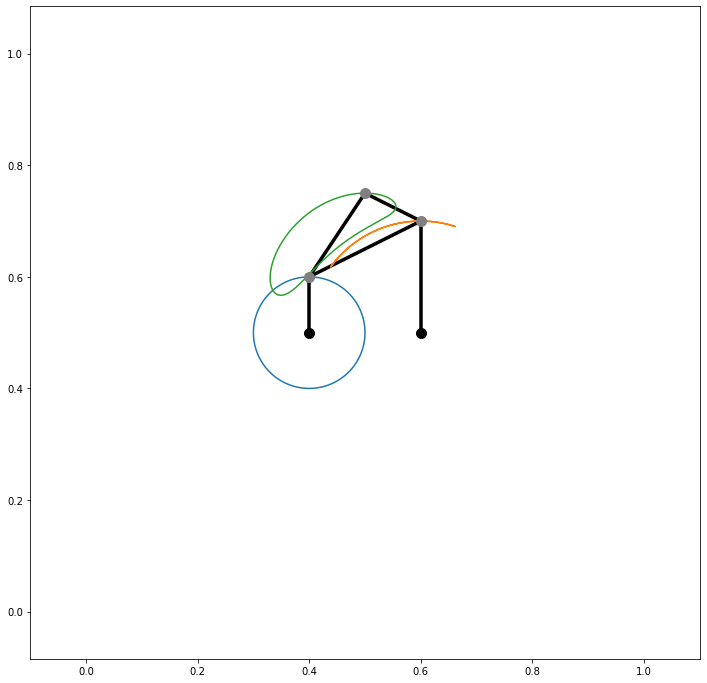

In [3]:
draw_mechanism(C,x0,fixed_nodes,motor)

### Mechanism Representation For Submissions

we have made all the functions and examples provided to you based around the representation of the mechanism discussed prior. However, to allow for students to work on different platforms and programming languages we have come up with a different representation which you will use to submit your results. Don't worry: we have also included functions within python to convert the previous representation into this representation.

For the submission we use the same basic 4 components to define the representation of the mechanism, however we flatten all matrices and arrays into a single dimensional array. Further, we also require you to specify the target node (The node which has the desirable trace) The format of this representation is as follows:

<ol>
    <li><b>Number of Nodes:</b> The number of nodes in the mechanism will go at the start of the array. See figure below.</li>
    <li><b>Adjacency/Connectivity Matrix: </b> Each row of the matrix will placed after the previous in the same order. See figure below.</li>
    <li><b>Node Types: </b>Instead of a list of the fixed nodes we will have N elements after the adjacency array which reflect the type of each node (1 if ground and 0 if ordinary node). See figure below.</li>
    <li><b>Initial Positions: </b> Similar to adjacency matrix, this time the two positions of each node will be placed right after the previous node. See figure below.</li>
    <li><b>Motor: </b>Similar what we had before just appended to the rest of the representation. See figure below.</li>
    <li><b>Target: </b>The number of the node to be assessed as a single number from 0 to N-1 append to the end of the representation array. See figure below.</li>
</ol>

<img src="https://i.ibb.co/ZVbGK19/untitled-1.png" alt="representation" border="0">

#### Example:
Take the previous mechanism (Note that target it the last node or node number 4):

<img src="https://i.ibb.co/qsPC0gC/2021-09-13-0hl-Kleki.png" alt="Numbered Mechanism" border="0">

For this mechanism we have already defined the the Connectivity Matrix (<code>C</code>), initial positions matrix (<code>x0</code>), motor linkage (<code>motor</code>), and a list of fixed nodes(<code>fixed_nodes</code>). We need to define the mechanism length (<code>N</code>), convert the list of fixed nodes to our our node type array (<code>node_types</code>) and define the target node (<code>target_node</code>). Finally, we flatten all of these components and concatenate them:

In [4]:
# Get the size of the mechanism in this case 5
N = C.shape[0]

# Make the list of node types (set all to zero or ordinary)
node_types = np.zeros([N])

# Set the ground nodes
node_types[fixed_nodes] = 1

# Set the target
target_node = 4

# Concatenate to make the final representaion
final_representation = np.concatenate([[N],C.reshape(-1),x0.reshape(-1),node_types,motor,[target_node]])

To make things easier we have provided the <code>to_final_representation(C,x0,fixed_nodes,motor,target)</code> function to you in the <code>linkage_utils</code> module. We also have provided the <code>from_1D_representation(mechanism)</code> function which returns <code>C,x0,fixed_nodes,motor,target</code> from the 1D representation, essentially reversing the process.

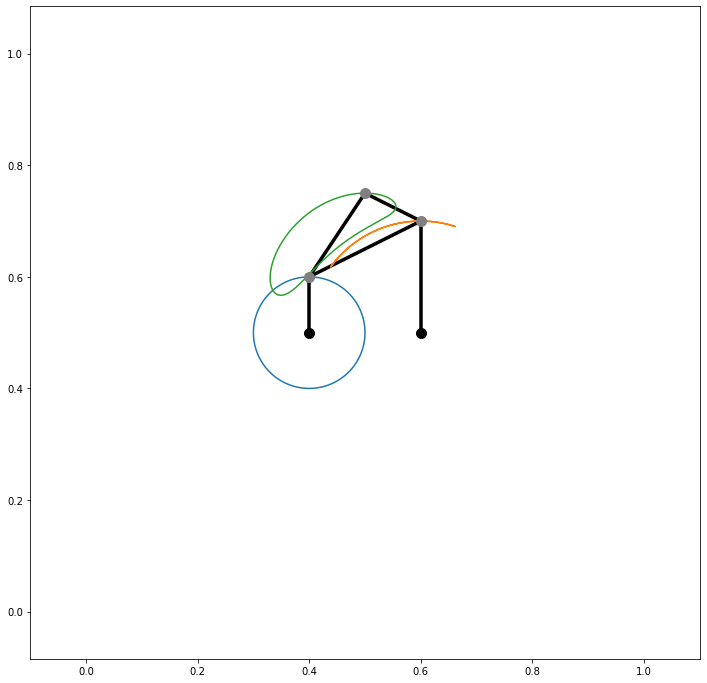

In [5]:
# Get 1D representaion
final_representation = to_final_represenation(C,x0,fixed_nodes,motor,target_node)

# Reverse The process
C,x0,fixed_nodes,motor,target = from_1D_representation(final_representation)

# Darw to ensure everything went as expected
draw_mechanism(C,x0,fixed_nodes,motor)

### Submission Format

For your submissions we require a population of mechanisms (will be discussed later) for each target curve. For this purpose you must obtain 1D representations of each member of the population (for each target curve) and create a .csv file with all the mechanisms each in one row of the .csv file, up to 1000, which is the limit we restrict you to. You will submit a .csv file for each target curve, therefore you will have a total of 20 .csv files. We also ask that you submit the 20 .csv files as a zip file. The naming scheme for the submission will be #.csv where you replace # with the number of the target curve starting from 0.csv and up to 19.csv.

To make this part easier we have also provided a population to .csv function which will help you make the conversion from python array to .csv for all members of a population. Since we haven't actually generated any mechanisms yet, lets generate some random ones as a placeholder. First let's use the <code>random_generator_ns</code> function we have provided to you to generate 6 random mechanisms (Note: if you pass an <code>n=#</code> parameter to this function and set # to be any number the random mechanism will have that number of nodes). We will add these 6 mechanisms to our example population. 

  0%|          | 0/6 [00:00<?, ?it/s]

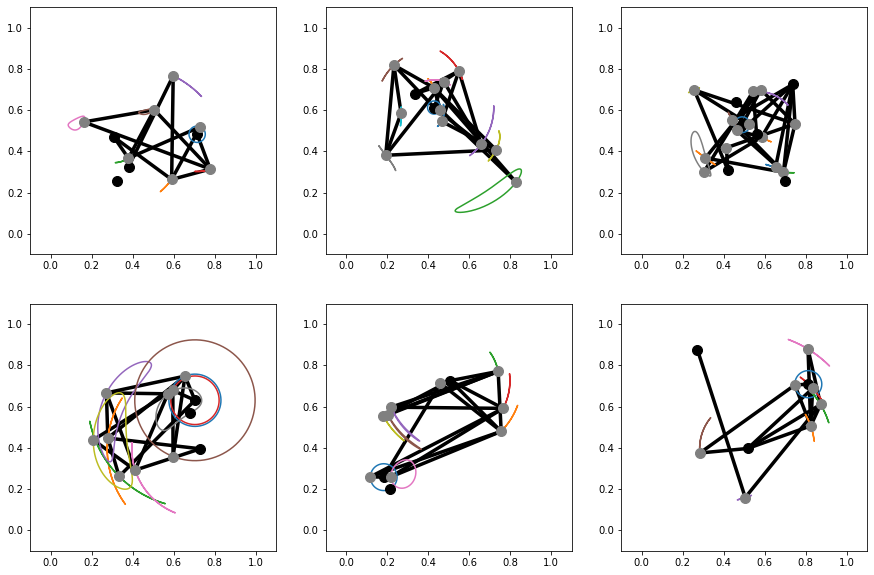

In [6]:
population = []

fig, axs = plt.subplots(2, 3,figsize=(15,10))
for i in trange(6):
    
    # Get random mechanims
    C,x0,fixed_nodes,motor = random_generator_ns()
    
    # Plot Mechanism
    draw_mechanism_on_ax(C,x0,fixed_nodes,motor,axs[i//3,i%3])
    
    # Set last node as dummy target
    target = C.shape[0]-1
    
    # Turn into 1D and add to the list of population memebers
    population.append(to_final_represenation(C,x0,fixed_nodes,motor,target))

Now use the provided <code>save_population_csv(file_name,population)</code> to save the list of mechanisms as a .csv file:

In [7]:
save_population_csv('test.csv',population)

You can also use the provided <code>get_population_csv(file_name)</code> to load the list of mechanisms as from a .csv file:

In [8]:
population_reloaded = get_population_csv('test.csv')

Now lets visualize the mechanisms to see if they match the originals:

  0%|          | 0/6 [00:00<?, ?it/s]

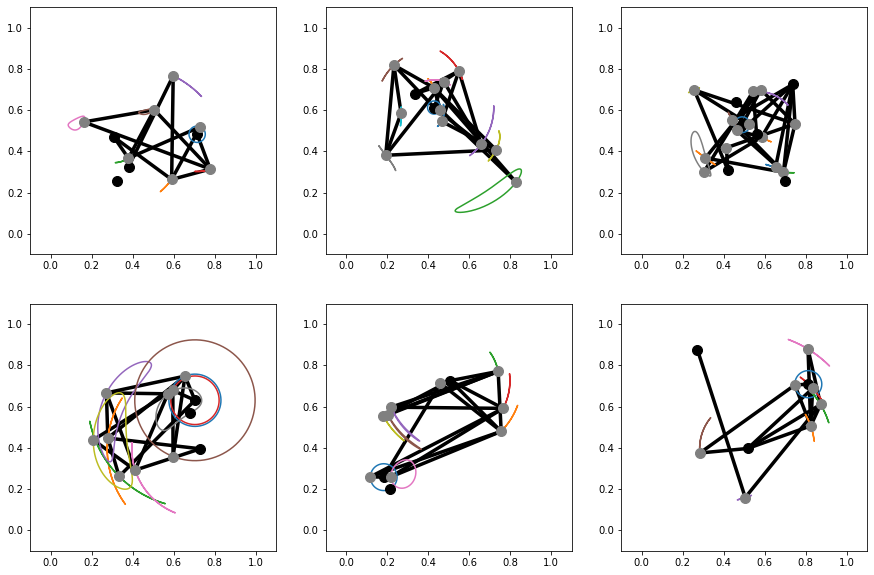

In [9]:
fig, axs = plt.subplots(2, 3,figsize=(15,10))
for i in trange(6):
    # Resverse 1D
    C,x0,fixed_nodes,motor,target = from_1D_representation(population[i])
    
    # Plot mechanism
    draw_mechanism_on_ax(C,x0,fixed_nodes,motor,axs[i//3,i%3])

### Target Curves and Project Objectives

The target curves are provided to you in a specific format. The curves are actually point clouds on a 500x500 grid. These curves are obtained from randomly generated mechanisms so they are all valid curves that 1 DOF planar mechanisms are capable of producing. The curves that are given to you were process as follows:

<ol>
    <li><b>Normalize: </b> The output of a node in the mechanisms is normalized using the normalizer instance we have provided to orient the output curve such that it has it's maximum length along the x-axis. This will make the output orientation-invariant and the target provided will also have such normalized orientation. This way we don't worry about the orientation of the output curve rather the shape of it.</li>
    <li><b>Rasterize: </b> Finally the curve was rasterized to a point cloud with points standardized to a 500x500 grid of points. This way the timing of the output curve is removed and only the shape is kept, while the coordinates of the point cloud are also matched to the 500x500 grid. Look at Bresenham's line algorithm to get further details on this process or look at our <code>rasterized_curve_coords(curve,resolution)</code></li> in the <code>linkage_utils.py</code> file.
</ol>

Your tasked with generating mechanisms that are capable of producing curves that mimic the target curves as well as possible. We measure the closeness of two point clouds by computing the bi-directional chamfer distance between the two point clouds. Chamfer distance is calculated by:

$$
d_{C D}\left(S_{1}, S_{2}\right)=\sum_{x \in S_{1}} \min _{y \in S_{2}}\|x-y\|_{2}^{2}+\sum_{y \in S_{2}} \min _{x \in S_{1}}\|x-y\|_{2}^{2}
$$

See our <code>chamfer_distance(curve1,curve2)</code> implementation in <code>linkage_utils.py</code> for implementation details in python.

<img src="https://i.ibb.co/WznB1R8/compare.png" alt="compare" border="0">

The other part of the objective in this challenge problem is reducing the material used by the mechanism. This is the total length of all linkages. We have provided a function that makes this measurement for you using initial positions and adjacency matrix for a mechanism (The functions and useful tools are going to be described later).

[IMPORTANT] In this project three constraints are set for you:
<ul>
    <li><b>Chamfer Distance: </b>Any mechanisms output with a chamfer distance to the target curve larger than 30 (based on the 500x500 rasterized coordinates) will be considered invalid and will not be used to calculate the score of the submissions.</li>
    <li><b>Material Use: </b>Any mechanism with total linkage lengths more than 6.0 will be deemed invalid and will not be used to calculate the score of the submissions.</li>
    <li><b>Mechanism Complexity: </b>For this project we want you to generate mechanisms with no more than 20 nodes (i.e., <code>N<=20</code>).</li>
</ul>

Submitted mechanisms that violate these constraints will not be scored. 

#### Summary:

The problem in this project is a multi-objective optimization problem where you are tasked with generating entire planar mechanisms such that the output curve of the mechanism will be as close to the target as possible (judged by chamfer distance) while at the same time reducing the total length of the linkages used for the mechanism (i.e., material use). while ensuring members of the population with chamfer distance more than 30 or material use more than 6.0 are eliminated. 

### Project Files and Description of Functions Provided:

All files as well as helper functions and this notebook and further information can be found in the Github repository of this challenge problem:

[Github Repo](https://github.com/ahnobari/MOOMP)

#### Target Curves

We provide a data folder containing .csv files of the target curves. This folder includes 20 .csv files with the coordinates of the target curve point clouds in each .csv file starting from 0.csv and ending with 19.csv. Now we will demonstrate how you can load these files into Python. 

In [10]:
target_curves = []

# Read every file separately and append to the list
for i in range(20):
    target_curves.append(np.loadtxt('./data/%i.csv'%(i),delimiter=','))

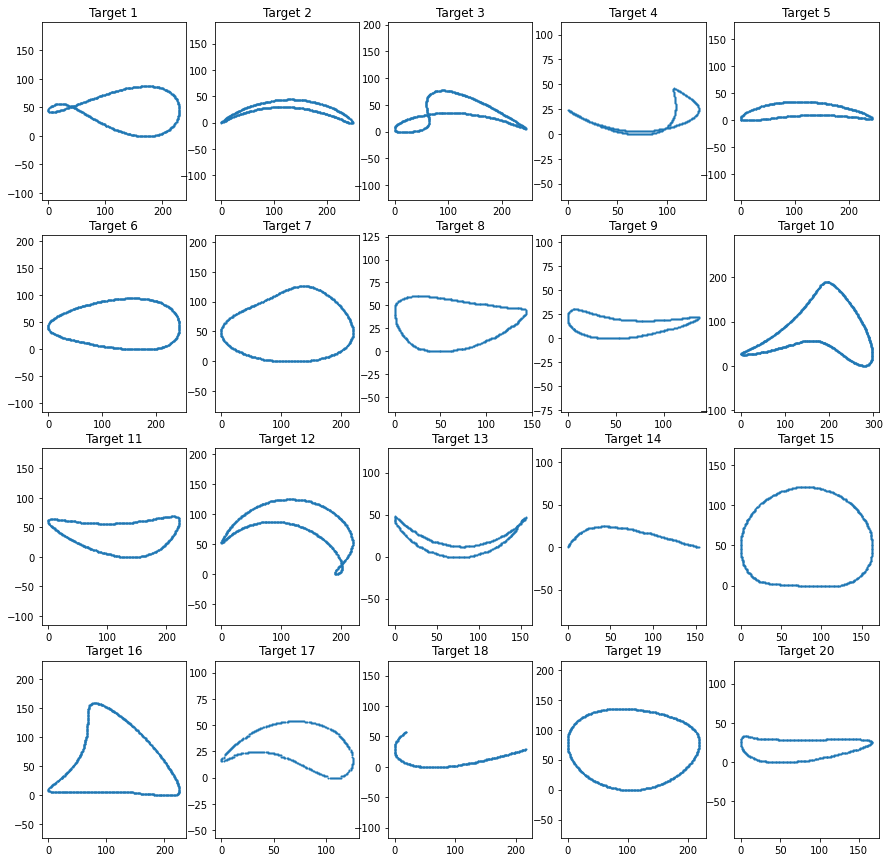

In [11]:
# Plot all target curves
fig, axs = plt.subplots(4, 5,figsize=(15,15))
for i in range(20):
    axs[i//5,i%5].scatter(np.array(target_curves[i])[:,0],np.array(target_curves[i])[:,1],s=1)
    axs[i//5,i%5].set_title('Target %i'%(i+1))
    axs[i//5,i%5].axis('equal')

#### Code and Notebook Files:

you can find this notebook file as well as the notebook file for the in-class demo you had in September 15th in the Github repository. Aside from the Jupyter notebooks you will also find a file called <code>linkage_utils.py</code>. This file includes some useful tools and functions which can make things easier for you and speed up your project development. Below is a list of functions provided and how they can be used:

<ul>
    <li>
        <code>chamfer_distance(x, y)</code>: Given two sets of point clouds x and y this function returns a subsampled (approximate not exact to reduce computational cost) bi-directional chamfer distance. To get exact chamfer distance use <code>chamfer_distance(x, y,subsample=False)</code>.
    </li>
    <li>
        <code>rasterized_curve_coords(curve, res)</code>: Rasterizes given curve into a grid of specified resolution (res x res grid). This function returns a point cloud (coordinates of the rasterized curve).
    </li>
    <li>
        <code>draw_mechanism(C,x0,fixed_nodes,motor)</code>: This function plots a mechanisms and it's traced paths given the mechanisms components as described before.
    </li>
    <li>
        <code>draw_mechanism_on_ax(C,x0,fixed_nodes,motor,ax)</code>: This function plots a mechanisms and it's traced paths given the mechanisms components as described before. The difference between this and the previous is that the mechanism will be drawn on a Matplotlib axes object (which is passed as ax to the function), this gives you control over the plot itself if needed.
    </li>
    <li>
        <code>mechanism_solver()</code>: A class, which initiates an instance of a solver for the mechanism. This class has several useful functions within it:<br><br><br>
        <ul>
            <li>
                <code>solve_rev(n_steps, x0, C, motor, fixed_nodes, show_msg)</code>: This function of the solver solves the mechanisms for a full revolution of the motor. The resolution of the solution is determined by the number of points use to discretize the solution (n_steps is the number of points between 0 and 2$\pi$ that will be set at the motor linkage to solve the system).
            </li>
            <li>
                <code>material(x0, C)</code>: This function of the solver calculates the material use (the total length of linkages) in a given mechanism. 
            </li>
        </ul>
        <br>
        This solver is based on:<br><b>Bacher, M., Coros, S., Thomaszewski, B. (2015). LinkEdit: interactive linkage editing using symbolic kinematics. ACM Transactions on Graphics (TOG), 34(4), 99.</b><br><br>
    </li>
    <li>
        <code>random_generator_ns(g_prob = 0.15, n=None, N_min=8, N_max=20, strategy='rand')</code>: This function returns random mechanisms which are valid (not under or over defined and not locking). All parameters are optional and not necessary. The most important is n which if set will give random mechanisms of size n. For further information refer to the functions docstring (look at the <code>linkage_utils.py</code> file).Use <code>batch_random_generator(N,g_prob = 0.15, n=None, N_min=8, N_max=20, strategy='rand')</code> to generate N random mechanims fast(much faster).
    </li>
    <li>
        <code>curve_normalizer(scale)</code>: Initializes an instance of the normalizer. The scale parameter refers to whether the normalization is scale invariant. If True it will normalize the scales of the mechanisms as well. In this project always set this to False as the curves are not scale invariant. This class has several useful functions within it:<br><br>
        <ul>
            <li>
                <code>get_oriented(curve)</code>: This function will return the normalized version of the input curve.
            </li>
            <li>
                <code>__call__(curves)</code>: This function performs the same on a batch of curves instead of one curve. The input to this is a list of curves.
            </li>
        </ul>
        <br>
    </li>
    <li>
        <code>PolyArea(x,y)</code>: Area of a polygon given the coordinates of the polygon points (x is a list of x coordinates and y is a list of y coordinates).
    </li>
    <li>
        <code>to_final_representation(C,x0,fixed_nodes,motor,target)</code>: As seen before.
    </li>
    <li>
        <code>from_1D_representation(mechanism)</code>: As seen before.
    </li>
    <li>
        <code>save_population_csv(file_name, population)</code>: As seen before.
    </li>
    <li>
        <code>get_population_csv(file_name)</code>: As seen before.
    </li>
</ul>

Now we will try these functions and see how they can be applied. Let's start with the last random curve that we have:

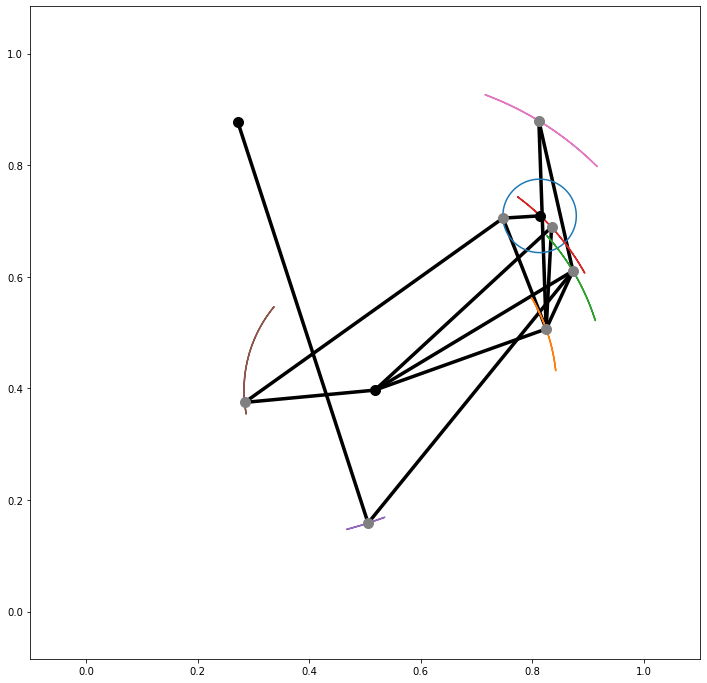

In [12]:
draw_mechanism(C,x0,fixed_nodes,motor)

Now let's get the simulation results:

Material Used: 9.073255


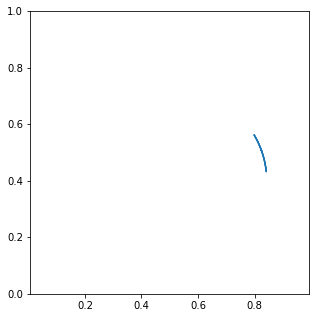

In [13]:
# First start a solver instance
solver = mechanism_solver()

# Now let's get the solution for 200 point descretization
x_sol,locking,over_under_defined = solver.solve_rev(200,x0,C,motor,fixed_nodes,False)

# Note that locking and over_under_defined outputs if true mean that the mechanims is locking or under/over defined respectively.

# Lets pick a random target
target = 3

# Lets see what the output of the 4th node is
plt.figure(figsize=(5,5.2))
plt.plot(x_sol[:,target,0],x_sol[:,target,1])
plt.axis('equal')
plt.xlim([0,1])
plt.ylim([0,1])

# Now lets compute material use:
material = solver.material(x0,C)

print('Material Used: %f' % (material))

Now lets see how the normalizer works:

(0.0, 1.0)

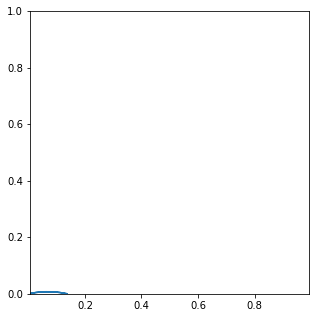

In [14]:
# Make a normalizer instance
normalizer = curve_normalizer(scale=False)

# Normalize the target curve
x_norm = normalizer.get_oriented(x_sol[:,target,:])

# Lets see what the normalized output of the 4th node is
plt.figure(figsize=(5,5.2))
plt.plot(x_norm[:,0],x_norm[:,1])
plt.axis('equal')
plt.ylim([0,1])
plt.xlim([0,1])

Now let's see how the rasterization works:

(-3.4000000000000004, 71.4, -0.15000000000000002, 3.15)

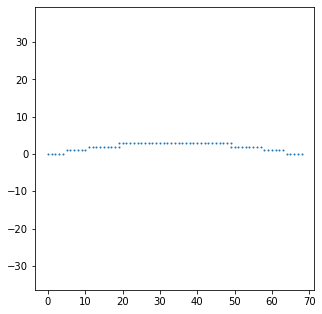

In [15]:
# Rasterize to 500x500 grid
out_pc = rasterized_curve_coords(x_norm,500)

# Lets see what the output of the 4th node is
plt.figure(figsize=(5,5.2))
plt.scatter(out_pc[:,0],out_pc[:,1],s=1)
plt.axis('equal')

Now let's get chamfer distance between this curve and target number 13 (14th since indexing starts from 0):

Chamfer Distance: 49.109791


(-7.7, 161.7, -1.25, 26.25)

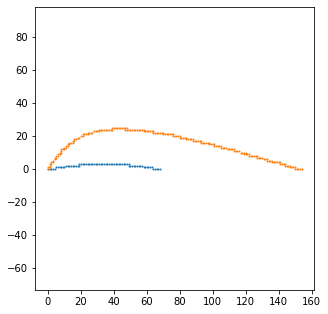

In [16]:
# Compute Chamfer Distance
cd = chamfer_distance(out_pc,target_curves[13],subsample=False)
print("Chamfer Distance: %f"%(cd))

# Lets plot the overlay
plt.figure(figsize=(5,5.2))
plt.scatter(out_pc[:,0],out_pc[:,1],s=1)
plt.scatter(target_curves[13][:,0],target_curves[13][:,1],s=1)
plt.axis('equal')

### Setting up Multi-Objective Optimization With Constraints Using Pymoo

Now that we have established the details to the project lets setup the problem in Pymoo and run an example. Here we will also discuss how your submissions are going to be evaluated to get your final score.

To setup the problem within Pymoo we will have to come up with a 1D representation of the mechanisms. We have already done that. However, we can make things a little more efficient as we know the connectivity matrix is symmetric and has a diagonal equal to zero, so instead of having the optimization come up with the whole connectivity matrix we will only have it come up with the upper triangular half of the matrix (Not including the diagonal). This means the algorithm has to come up with $\frac{N^2-N}{2}$ 0s or 1s (i.e., booleans) to construct the adjacency matrix. But we can further simplify the process by starting from a motor and having the optimization build the rest of the mechanism, removing the need for the optimization to determine the motor as well as reducing the number of 0s and 1s in the upper triangular portion by one (Saving 3 parameters in the representation). To do this we will start with the following mechanism (<b>The random generator also does this by default!</b>):

<img src="https://i.ibb.co/mGywWgr/start.jpg" alt="start" border="0">

We set Node 0 to ground and Node 1 to be ordinary and the motor to be <code>[0,1]</code>. Now we know that the upper triangular portion of the connectivity matrix starts with:

<img src="https://i.ibb.co/5RqKYQN/upper-triangular-fromstart.jpg" alt="upper-triangular-fromstart" border="0">

As mentioned before we also now know the types of the first two nodes which saves another two parameters from the optimization. At this point we will have the same representation as we have before, but with fewer numbers and no motor or N (size of mechanisms) as we generate the mechanism to have a certain size.

<img src="https://i.ibb.co/gv2D0Y5/Optimization-Represenation.png" alt="Optimization-Represenation" border="0">

Now that we know how to represent mechanisms for optimization (<b>actually this is a naive representation - you can think about how to improve this</b>) we will setup our problem with this many parameters. But note that the types of parameters are different. So we also have to tell Pymoo to treat them as the correct types of parameters (for C we need 0 or 1 (Boolean), for x0 we need real numbers (floating point), for node types we need 0 or 1 (Boolean), and for target we need an Integer). We do this by creating a mask (a list of parameter types with the same length as the parameters numbers), while also specifying the lower and upper limits of each parameter separately (by again creating two lists (with the same length as the number of parameters in the representation) with one holding the lower and the other holding the upper limit on the parameters).

Finally, don't forget that we need to also have our constraints in mind. In this representation, you control the size directly. For the chamfer distance and material, however, we have to let Pymoo know what our constraints are. Inequality constraints can be set in Pymoo (See: [constraints in pymoo](https://www.pymoo.org/misc/constraints.html?highlight=const)) as less than or equal to zero constraints. We will set the two constraints on chamfer distance and material use in our problem.

So based on this lets get started with defining the problem in Pymoo. 
<ul>
    <li>
        <code>__init__</code>: Pymoo expects a datatype as well as lower and upper bound for each "gene" (parameter in our parameterization). In practice, we will pass Pymoo a vector of upper bounds <code>xu</code> and lower bounds <code>xl</code> as well as a vector of datatypes <code>self.mask</code>. We need to differentiate between datatypes because crossover, sampling, and mutation will happen slightly differently based on datatype.
    </li>
    <li>
<code>construct_mechanism</code>: Converts from our flattened 1D representation to usable design info. This function is relatively long and boring, but you will need to update it if you change the way you parameterize mechanisms.
    </li>
    <li>
<code>get_1D_representation</code>: Converts from usable design info to 1D representation. Again, you will need to update it if you change the way you parameterize mechanisms.
    </li>
    <li>
<code>_evaluate</code>: Next, we define the evaluation function. We construct and solve the mechanism using <code>construct_mechanism</code> and the given helper functions. If the mechanism is locking or over/underdefined, we set the objective scores to infinity. We then normalize, rasterize, calculate the bidirectional chamfer distance to the target, and evaluate the material usage. This will give us our two scoring objectives for this particular mechanism.
    </li>
</ul>

In [17]:
class mechanism_synthesis_optimization(ElementwiseProblem):
    
    # When intializing, set the mechanism size and target curve
    def __init__(self,target_point_cloud,mech_n = 15):
        
        # Get the number of parameters given size
        # half of adjacency matrix - 1 (node 1 is connected to node 0) + positions + types - 2 initial node types + 1 target
        N_params = (mech_n**2 - mech_n)//2 - 1 + 2 * mech_n + mech_n - 2 + 1
        self.mech_n = mech_n
        
        # set upper bound for all to be 1.0 for now
        xu = [1.0] * N_params
        
        # set upper bound for last parameter to be N-1(maximum Node Number) (recall that our last parameter is our target)
        xu[-1] = mech_n - 1
        
        # set lower bound for all to be 0.0 for now
        xl = [0.0] * N_params
        # correct lower bound for target to be 2 (anything bu the first ground or motor)
        xl[-1] = 2
        
        # Set variable types (bin is binary or boolean, real is floating point, and int is integer) 
        self.mask = ["bin"]  * ((mech_n**2 - mech_n)//2 - 1) + ["real"] * 2 * mech_n + ["bin"] * (mech_n - 2) + ["int"]
        
        
        # get Correct Sampling, Mutation, and Crossovers For NSGA
        self.sampling = MixedVariableSampling(self.mask, {
            "real": get_sampling("real_random"),
            "int": get_sampling("int_random"),
            "bin": get_sampling("bin_random")
        })

        self.crossover = MixedVariableCrossover(self.mask, {
            "real": get_crossover("real_sbx", prob=1.0, eta=3.0),
            "int": get_crossover("int_sbx", prob=1.0, eta=3.0),
            "bin": get_crossover("bin_hux")
        })

        self.mutation = MixedVariableMutation(self.mask, {
            "real": get_mutation("real_pm", eta=3.0),
            "int": get_mutation("int_pm", eta=3.0),
            "bin": get_mutation("bin_bitflip")
        })
        
        # Set up problem for pymoo
        # n_obj=number of objectives, xl=lower bound for the parameters, xu=upper bound for the paramters, 
        # n_constr=number of constraints
        # Our objectives are chamfer disntance and material, and they bnoth have constraints as well
        super().__init__(n_var = N_params, n_obj=2, xl=xl, xu=xu, n_constr=2)
        
        # Store the target curve point cloud
        self.tpc = target_point_cloud
        
        # Make a solver instance
        self.solver = mechanism_solver()
        
        # Make a normalizer instance
        self.normalizer = curve_normalizer(scale=False)

        
    def _evaluate(self, x, out, *args, **kwargs):

        # Step 1: Reshape
        C,x0,fixed_nodes,motor,target = self.construct_mechanism(x)

        # Step 2: Simulate
        x_sol,locking,over_under_defined = self.solver.solve_rev(200,x0,C,motor,fixed_nodes,False)

        # check to see if the mechanism is valid
        if locking or over_under_defined:
            # if mechanism is invalid set the objective to infinity
            out["F"] = [np.Inf,np.Inf]
            out["G"] = [np.Inf,np.inf]
        else:
            # Step 3: Normalize
            x_norm = self.normalizer.get_oriented(x_sol[:,target,:])

            # Step 4: Rasterize
            out_pc = rasterized_curve_coords(x_norm,500)

            # Step 5: Compare
            cd = chamfer_distance(out_pc,self.tpc)

            # Send the chamfer distance to pymoo as objective
            m = self.solver.material(x0,C)
            out["F"] = [cd,m]

            # Set constraints as CD<=30 and Material<=6
            # Be careful about modifying these - designs that 
            # violate the problem constraints will not be scored.
            out["G"] = [cd - 30, m - 6]

    def construct_mechanism(self, x):

        # This function transforms mechanism representation to python represenation
        N = self.mech_n

        # Set fixed nodes
        fixed_nodes = [0]

        # This is where the fixed nodes portion starts in the 1D array
        st = ((self.mech_n**2 - self.mech_n)//2 - 1) + 2 * self.mech_n

        # Go through node types and make a list of ground nodes
        for i in range(N-2):
            if x[st+i]:
                fixed_nodes.append(2+i)

        # Setup empty adjacency matrix
        C = np.zeros([N,N]).astype(np.bool)

        # Set Adjancecy on motor (the starting configuration)
        C[1,0] = True
        C[0,1] = True

        # construct adjancency matrix
        count = 0
        for i in range(2,N):
            for j in range(i):
                # To make it a little easier correct the mistakes of the algorithm
                # if it has connected to ground nodes. Althogh this is not going to 
                # cause failure it will waste material, we eliminate this to make a 
                # bit easier on the algortihm
                if not (i in fixed_nodes and j in fixed_nodes):
                    C[i,j] = x[count]
                    C[j,i] = x[count]

                count += 1


        # Setup empty intial positions
        x0 = np.zeros([N,2])

        st = ((self.mech_n**2 - self.mech_n)//2 - 1)

        # construct intial position matrix
        for i in range(N):
            x0[i,0] = x[st + 2*i]
            x0[i,1] = x[st + 2*i + 1]

        # Set fixed nodes
        fixed_nodes = [0]

        # This is where the positions portion starts in the 1D array
        st = ((self.mech_n**2 - self.mech_n)//2 - 1) + 2 * self.mech_n

        # Get the positions of each node and make the initial position matrix
        for i in range(N-2):
            if x[st+i]:
                fixed_nodes.append(2+i)

        # Set motor (We know this)
        motor = [0,1]

        # Get target (Last element of array)
        target = x[-1]

        return C,x0,np.array(fixed_nodes),motor,int(target)

    def get_1D_representaion(self,C,x0,fixed_nodes,motor,target):

        C,x0,fixed_nodes,motor,target = np.array(C),np.array(x0),np.array(fixed_nodes),np.array(motor),np.array(target)
        # This function transforms python representation to 1D represenation
        N = self.mech_n

        rep = []

        # Put the useful part of C in the 1D array 
        for i in range(2,N):
            for j in range(i):
                if C[i,j]:
                    rep.append(1)
                else:
                    rep.append(0)

        # Put position matrix into 1D array
        for i in range(N):
            rep.append(x0[i,0])
            rep.append(x0[i,1])

        # Get node types
        for i in range(N-2):
            if (i+2) in fixed_nodes.tolist():
                rep.append(1)
            else:
                rep.append(0)

        # Add target
        rep.append(target)

        return np.array(rep)



Now let's try this with NSGA-II and one of the target curves. We will initialize with mechanisms with 5 nodes. You can test what happens if you increase this number. You should quickly discover that this naive parameterization does not perform well when initializing the GA with more complex mechanisms:

(-12.15, 255.15, -4.75, 99.75)

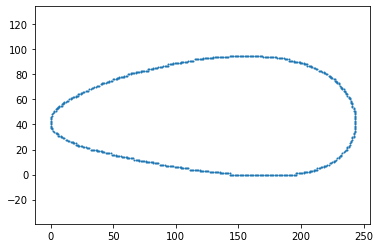

In [18]:
# Get target curve 6 (index 5)
target_index = 5
target_curve = np.array(target_curves[target_index])
plt.scatter(target_curve[:,0],target_curve[:,1],s=1)
plt.axis('equal')

In [19]:
# Setup Problem
problem = mechanism_synthesis_optimization(target_curve,5)

# Get Algorithm
algorithm = NSGA2(pop_size=50,
                  sampling=problem.sampling,
                  crossover=problem.crossover,
                  mutation=problem.mutation,
                  eliminate_duplicates=True)

# Run for 150 generations
results = minimize(problem,
                   algorithm,
                   ('n_gen', 150),
                   verbose=True,
                   save_history=True,
                   seed=28,
                   display=best())

n_gen |  n_eval | Lowest Memeber for Objective 0 | Lowest Memeber for Objective 1
    1 |      50 |  1.14466E+02 |  1.817244163
    2 |     100 |  7.38744E+01 |  1.817244163
    3 |     150 |  7.38744E+01 |  0.560747528
    4 |     200 |  7.38744E+01 |  0.560747528
    5 |     250 |  7.38744E+01 |  0.513252222
    6 |     300 |  7.38744E+01 |  0.333793184
    7 |     350 |  7.38744E+01 |  0.280838937
    8 |     400 |  7.38744E+01 |  0.380944402
    9 |     450 |  7.38744E+01 |  0.380944402
   10 |     500 |  7.38744E+01 |  0.380944402
   11 |     550 |  7.38744E+01 |  0.158292715
   12 |     600 |  7.38744E+01 |  0.158292715
   13 |     650 |  7.38744E+01 |  0.158292715
   14 |     700 |  7.32993E+01 |  0.158292715
   15 |     750 |  7.32993E+01 |  0.158292715
   16 |     800 |  5.66289E+01 |  0.158292715
   17 |     850 |  5.66289E+01 |  0.158292715
   18 |     900 |  5.66289E+01 |  0.278430242
   19 |     950 |  5.66289E+01 |  0.305453485
   20 |    1000 |  3.75903E+01 |  0.58696741

Pymoo automatically saves the optimal set of solutions(<code>results.X</code> will contain the solutions in 1D representation and <code>results.F</code> will contain the objectives. Note that if none of the solutions meet the constraints, the algorithm will not save anything on the best solutions). The constraints that we set at the start basically define a reference point with respect to which we will measure your submissions performance. Your performance on the targets will be measured based on the hyper volume calculated from the population to the reference point. Note that there is a limit on the number of mechanisms you are permitted to submit as potential solutions for any given curve (1000). The closer you get to ideal the higher the score you will receive. The total score for your submission will be the average hypervolume for all 20 target curves:

Hyper Volume ~ 72.006654


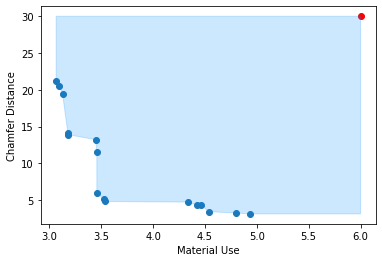

In [20]:
if not results.X is None:
    plt.scatter(results.F[:,1],results.F[:,0])
    plt.scatter([6],[30],color="red")
    plt.xlabel('Material Use')
    plt.ylabel('Chamfer Distance')
    sorted_performance = results.F[np.argsort(results.F[:,1])]
    sorted_performance = np.concatenate([sorted_performance,[[np.min(results.F[:,0]),6],[30,6],[30,np.min(results.F[:,1])]]])
    plt.fill(sorted_performance[:,1],sorted_performance[:,0],color="#008cff",alpha=0.2)

    print('Hyper Volume ~ %f' % (hyper_volume(results.F,[30.0,6.0])))
else:
    print('Did Not Find Solutions!!')

Now lets plot the results for the best chamfer distance solution

In [21]:
if not results.X is None:
    if results.X.ndim >1:
        best_sol = results.X[np.argmin(results.F[:,0])]
    else:
        best_sol = results.X
else:
    print('Did Not Find Solutions!!')        

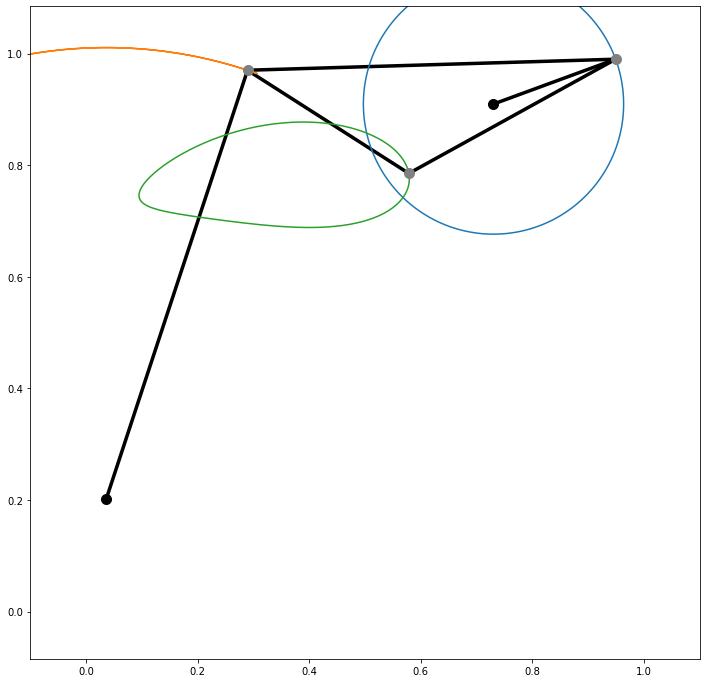

In [22]:
if not results.X is None:
    # Step 1: Reshape
    C,x0,fixed_nodes,motor,target = problem.construct_mechanism(best_sol)

    # Step 2: Draw
    draw_mechanism(C,x0,fixed_nodes,motor)
else:
    print('Did Not Find Solutions!!')   

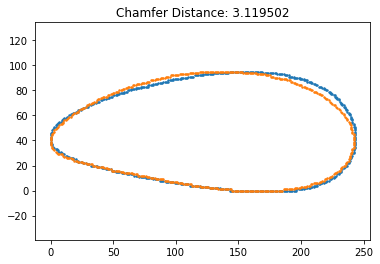

In [23]:
if not results.X is None:
    # Get a solver instance
    solver = mechanism_solver()

    # Solve
    x_sol, locking,over_under_defined = solver.solve_rev(200,x0,C,motor,fixed_nodes,False)

    # Get a solver normalizer
    normalizer = curve_normalizer(scale=False)

    # Normalize
    x_norm = normalizer.get_oriented(x_sol[:,target,:])

    # Step 4: Rasterize
    out_pc = rasterized_curve_coords(x_norm,500)

    # Plot
    plt.scatter(target_curve[:,0],target_curve[:,1],s=2)
    plt.scatter(out_pc[:,0],out_pc[:,1],s=2)
    plt.axis('equal')

    plt.title('Chamfer Distance: %f'%(chamfer_distance(out_pc,target_curve)))
else:
    print('Did Not Find Solutions!!')   

Now lets see the solution with the least material use

In [24]:
if not results.X is None:
    if results.X.ndim >1:
        best_sol = results.X[np.argmin(results.F[:,1])]
    else:
        best_sol = results.X
else:
    print('Did Not Find Solutions!!')   

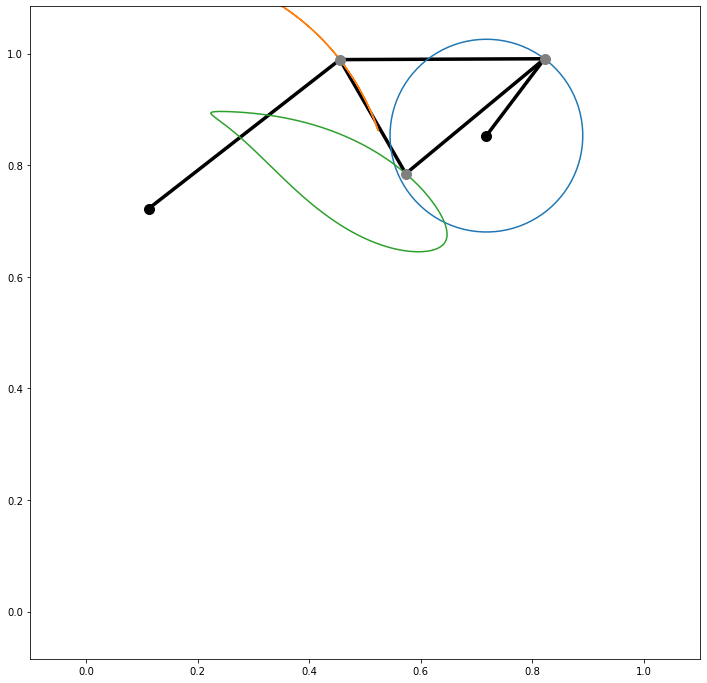

In [25]:
if not results.X is None:
    # Step 1: Reshape
    C,x0,fixed_nodes,motor,target = problem.construct_mechanism(best_sol)

    # Step 2: Draw
    draw_mechanism(C,x0,fixed_nodes,motor)
else:
    print('Did Not Find Solutions!!')   

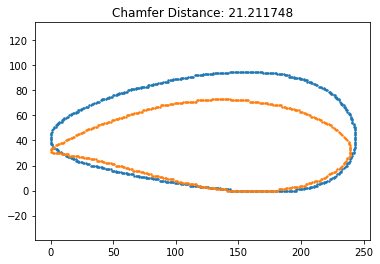

In [26]:
if not results.X is None:
    # Get a solver instance
    solver = mechanism_solver()

    # Solve
    x_sol, locking,over_under_defined = solver.solve_rev(200,x0,C,motor,fixed_nodes,False)

    # Get a solver normalizer
    normalizer = curve_normalizer(scale=False)

    # Normalize
    x_norm = normalizer.get_oriented(x_sol[:,target,:])

    # Step 4: Rasterize
    out_pc = rasterized_curve_coords(x_norm,500)

    # Plot
    plt.scatter(target_curve[:,0],target_curve[:,1],s=2)
    plt.scatter(out_pc[:,0],out_pc[:,1],s=2)
    plt.axis('equal')

    plt.title('Chamfer Distance: %f'%(chamfer_distance(out_pc,target_curve)))
else:
    print('Did Not Find Solutions!!')   

Now lets visualize the pareto front of the last generation

  0%|          | 0/16 [00:00<?, ?it/s]

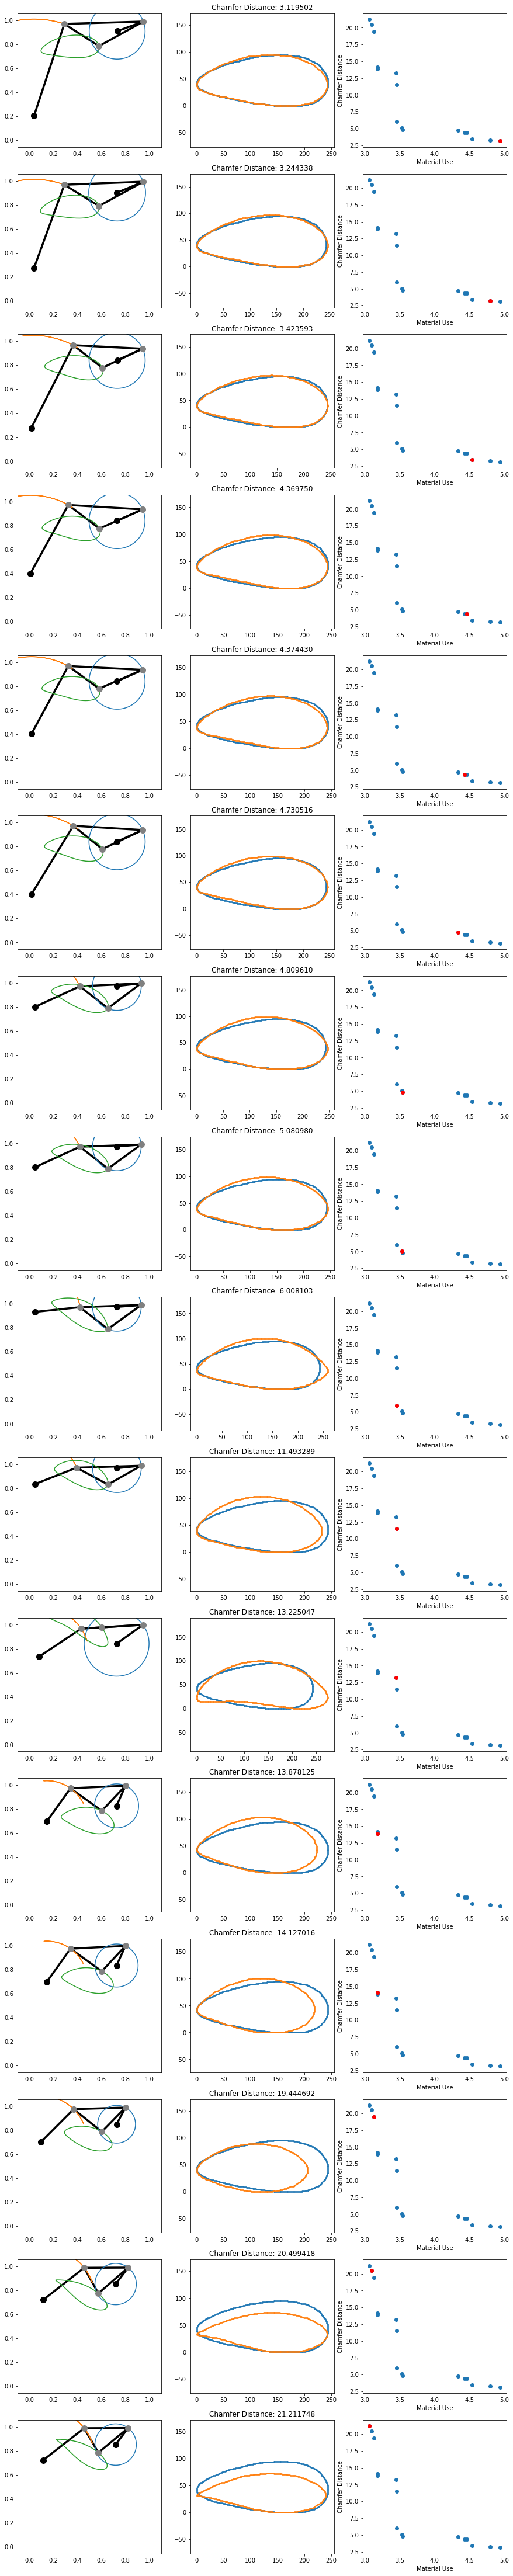

In [27]:
if not results.X is None:
    # first get generalized 1D representation
    mechanisms = []

    for x in results.pop.get("X"):
        C,x0,fixed_nodes,motor,target = problem.construct_mechanism(x)
        mechanisms.append(to_final_represenation(C,x0,fixed_nodes,motor,target))
    
    # Visualize Pareto Front
    visualize_pareto_front(np.array(mechanisms),results.pop.get("F"),target_curve)
else:
    print('Did Not Find Solutions!!')

At this point lets save our population for submission as a csv.

In [28]:
if not results.X is None:
    save_population_csv('./results/%i.csv'%target_index,mechanisms)
else:
    print('Did Not Find Solutions!!')

To get a score for a submission place all 20 .csv files for in the results folder. Then you can get your overall score by running the following function in the main directory:

In [29]:
evaluate_submission()

  0%|          | 0/20 [00:00<?, ?it/s]

Score Break Down:
Curve 0: 0.000000
Curve 1: 0.000000
Curve 2: 0.000000
Curve 3: 0.000000
Curve 4: 0.000000
Curve 5: 72.006649
Curve 6: 0.000000
Curve 7: 0.000000
Curve 8: 0.000000
Curve 9: 0.000000
Curve 10: 0.000000
Curve 11: 0.000000
Curve 12: 0.000000
Curve 13: 0.000000
Curve 14: 0.000000
Curve 15: 0.000000
Curve 16: 0.000000
Curve 17: 0.000000
Curve 18: 0.000000
Curve 19: 0.000000
Overall Score: 3.600332


3.600332454120843

Alternatively you can run the following command in the terminal (loaded to the main directory of the repo):

In [30]:
!python evaluate.py

100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 19.34it/s]
Score Break Down:
Curve 0: 0.000000
Curve 1: 0.000000
Curve 2: 0.000000
Curve 3: 0.000000
Curve 4: 0.000000
Curve 5: 72.006649
Curve 6: 0.000000
Curve 7: 0.000000
Curve 8: 0.000000
Curve 9: 0.000000
Curve 10: 0.000000
Curve 11: 0.000000
Curve 12: 0.000000
Curve 13: 0.000000
Curve 14: 0.000000
Curve 15: 0.000000
Curve 16: 0.000000
Curve 17: 0.000000
Curve 18: 0.000000
Curve 19: 0.000000
Overall Score: 3.600332


### Now Let's Get a Submission Going

Now lets run the process for all the target curves in a loop:

n_gen |  n_eval | Lowest Memeber for Objective 0 | Lowest Memeber for Objective 1
    1 |      50 |  1.18666E+02 |  1.817244163
    2 |     100 |  8.59565E+01 |  1.817244163
    3 |     150 |  8.59565E+01 |  0.560747528
    4 |     200 |  7.51539E+01 |  0.560747528
    5 |     250 |  7.51539E+01 |  0.560747528
    6 |     300 |  7.51539E+01 |  0.466087159
    7 |     350 |  7.51539E+01 |  0.296880888
    8 |     400 |  7.51539E+01 |  0.251783544
    9 |     450 |  7.51539E+01 |  0.296880888
   10 |     500 |  7.51539E+01 |  0.506559490
   11 |     550 |  7.51539E+01 |  0.548488571
   12 |     600 |  7.51539E+01 |  0.548488571
   13 |     650 |  5.28019E+01 |  0.548488571
   14 |     700 |  5.28019E+01 |  0.548488571
   15 |     750 |  4.86740E+01 |  0.681350877
   16 |     800 |  4.86740E+01 |  0.519994399
   17 |     850 |  4.86740E+01 |  0.877016679
   18 |     900 |  4.86740E+01 |  0.890303338
   19 |     950 |  4.86740E+01 |  1.112089777
   20 |    1000 |  4.86740E+01 |  1.58242031

   18 |     900 |  6.28311E+01 |  0.239532225
   19 |     950 |  6.28311E+01 |  0.563661065
   20 |    1000 |  6.28311E+01 |  0.825939231
   21 |    1050 |  5.91864E+01 |  0.623275866
   22 |    1100 |  5.88111E+01 |  0.825939231
   23 |    1150 |  5.75416E+01 |  0.825939231
   24 |    1200 |  5.66399E+01 |  0.825939231
   25 |    1250 |  5.66399E+01 |  0.825939231
   26 |    1300 |  5.66399E+01 |  0.818658240
   27 |    1350 |  5.66399E+01 |  0.818658240
   28 |    1400 |  5.42272E+01 |  0.818658240
   29 |    1450 |  5.42272E+01 |  2.948685239
   30 |    1500 |  5.42272E+01 |  3.322283524
   31 |    1550 |  5.42272E+01 |  2.771347167
   32 |    1600 |  4.94402E+01 |  2.771347167
   33 |    1650 |  4.94402E+01 |  2.771347167
   34 |    1700 |  4.94402E+01 |  2.771347167
   35 |    1750 |  4.94402E+01 |  2.771347167
   36 |    1800 |  4.94402E+01 |  2.655664391
   37 |    1850 |  4.94402E+01 |  2.655664391
   38 |    1900 |  4.94402E+01 |  2.655664391
   39 |    1950 |  4.72990E+01 |  

   40 |    2000 |  9.611202041 |  0.208873006
   41 |    2050 |  9.611202041 |  0.263455407
   42 |    2100 |  9.611202041 |  0.263455407
   43 |    2150 |  9.611202041 |  0.263455407
   44 |    2200 |  9.611202041 |  0.549047653
   45 |    2250 |  9.611202041 |  0.549047653
   46 |    2300 |  9.611202041 |  0.347018560
   47 |    2350 |  9.611202041 |  0.347018560
   48 |    2400 |  9.611202041 |  0.347018560
   49 |    2450 |  9.611202041 |  0.347018560
   50 |    2500 |  9.611202041 |  0.840787458
   51 |    2550 |  9.611202041 |  2.109534506
   52 |    2600 |  9.611202041 |  2.705527885
   53 |    2650 |  9.611202041 |  3.174455081
   54 |    2700 |  9.611202041 |  3.174455081
   55 |    2750 |  9.611202041 |  3.174455081
   56 |    2800 |  7.292820691 |  3.174455081
   57 |    2850 |  7.292820691 |  3.174455081
   58 |    2900 |  7.292820691 |  3.044222468
   59 |    2950 |  7.292820691 |  3.044222468
   60 |    3000 |  7.292820691 |  3.044222468
   61 |    3050 |  7.292820691 |  

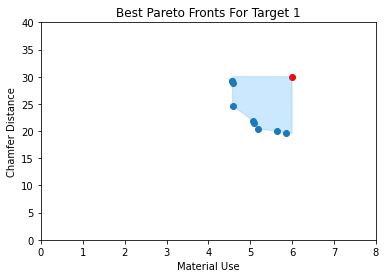

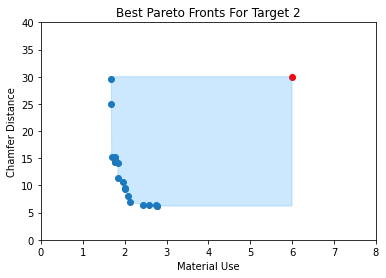

In [31]:
for i,target_curve in enumerate(target_curves):
    # Setup Problem
    problem = mechanism_synthesis_optimization(target_curve,5)

    # Get Algorithm
    algorithm = NSGA2(pop_size=50,
                      sampling=problem.sampling,
                      crossover=problem.crossover,
                      mutation=problem.mutation,
                      eliminate_duplicates=True)

    # Run for 150 generations
    results = minimize(problem,
                       algorithm,
                       ('n_gen', 150),
                       verbose=True,
                       save_history=True,
                       seed=28,
                       display=best())
    
    
    if results.X is None:
        print('Did Not Find Solutions!! Trying With A Different Seed!')
        # Run for 150 generations
        results = minimize(problem,
                           algorithm,
                           ('n_gen', 150),
                           verbose=True,
                           save_history=True,
                           seed=23,
                           display=best())
    
    if results.X is None:
        print('Did Not Find Solutions!! For target %i'%(i+1))
    else:
        mechanisms = []
        for x in results.X:
            C,x0,fixed_nodes,motor,target = problem.construct_mechanism(x)
            mechanisms.append(to_final_represenation(C,x0,fixed_nodes,motor,target))
        
        plt.figure()
        plt.scatter(results.F[:,1],results.F[:,0])
        plt.scatter([6],[30],color="red")
        plt.xlabel('Material Use')
        plt.ylabel('Chamfer Distance')
        plt.title('Best Pareto Fronts For Target %i'%(i+1))
        plt.xlim([0,8.0])
        plt.ylim([0,40.0])
        sorted_performance = results.F[np.argsort(results.F[:,1])]
        sorted_performance = np.concatenate([sorted_performance,[[np.min(results.F[:,0]),6],[30,6],[30,np.min(results.F[:,1])]]])
        plt.fill(sorted_performance[:,1],sorted_performance[:,0],color="#008cff",alpha=0.2)

        print('Hyper Volume For Target %i = %f' % ((i+1),hyper_volume(results.F,[30.0,6.0])))
        
        save_population_csv('./results/%i.csv'%i,mechanisms)

Now Let's see how we did:

In [32]:
evaluate_submission()

  0%|          | 0/20 [00:00<?, ?it/s]

Score Break Down:
Curve 0: 11.633996
Curve 1: 99.808121
Curve 2: 0.000000
Curve 3: 0.000000
Curve 4: 0.000000
Curve 5: 72.006649
Curve 6: 0.000000
Curve 7: 0.000000
Curve 8: 0.000000
Curve 9: 0.000000
Curve 10: 0.000000
Curve 11: 0.000000
Curve 12: 0.000000
Curve 13: 0.000000
Curve 14: 0.000000
Curve 15: 0.000000
Curve 16: 0.000000
Curve 17: 0.000000
Curve 18: 0.000000
Curve 19: 0.000000
Overall Score: 9.172438


9.17243825886126

### Extra Material and Challenges With the Current Implemenation

#### Some Important Notes:

<ul>
    <li><b>Random Seeds: </b>If you plan to run things in the notebook please do not forget to remove the random seeds from the code we set the seeds so that the results of the code do not change when you run them again, and you would obviously have better results if you randomize differently every time.</li>
    <li><b>Colab vs Local: </b>If you do plan to use Google Colab for your work remember to download any files you save and the changes to the notebook because every time Google Colab ends the runtime (or it times out) it deletes all files and progress. So <font color="red"><b>BE CAREFUL!</b></font></li> It is generally recommended that you work locally.
</ul>

#### Problems With The Current Implementation:

The current implementation has a few problems (your task is to improve upon this). The first is that the method cannot handle very large sizes of mechanisms and it can never find mechanisms that are not locking or under/over defined. Lets see the algorithm try to make mechanisms of size 12. To give it a chance lets run it for 1000 generations:

In [33]:
# Setup Problem
problem = mechanism_synthesis_optimization(target_curve,12)

# Get Algorithm
algorithm = NSGA2(pop_size=100,
                  sampling=problem.sampling,
                  crossover=problem.crossover,
                  mutation=problem.mutation,
                  eliminate_duplicates=True)

# Run for 150 generations
results = minimize(problem,
                   algorithm,
                   ('n_gen', 1000),
                   verbose=True,
                   save_history=True,
                   seed=1,
                   display=best())

n_gen |  n_eval | Lowest Memeber for Objective 0 | Lowest Memeber for Objective 1
    1 |     100 |          INF |          INF
    2 |     200 |          INF |          INF
    3 |     300 |          INF |          INF
    4 |     400 |          INF |          INF
    5 |     500 |          INF |          INF
    6 |     600 |          INF |          INF
    7 |     700 |          INF |          INF
    8 |     800 |          INF |          INF
    9 |     900 |          INF |          INF
   10 |    1000 |          INF |          INF
   11 |    1100 |          INF |          INF
   12 |    1200 |          INF |          INF
   13 |    1300 |          INF |          INF
   14 |    1400 |          INF |          INF
   15 |    1500 |          INF |          INF
   16 |    1600 |          INF |          INF
   17 |    1700 |          INF |          INF
   18 |    1800 |          INF |          INF
   19 |    1900 |          INF |          INF
   20 |    2000 |          INF |          IN

  174 |   17400 |          INF |          INF
  175 |   17500 |          INF |          INF
  176 |   17600 |          INF |          INF
  177 |   17700 |          INF |          INF
  178 |   17800 |          INF |          INF
  179 |   17900 |          INF |          INF
  180 |   18000 |          INF |          INF
  181 |   18100 |          INF |          INF
  182 |   18200 |          INF |          INF
  183 |   18300 |          INF |          INF
  184 |   18400 |          INF |          INF
  185 |   18500 |          INF |          INF
  186 |   18600 |          INF |          INF
  187 |   18700 |          INF |          INF
  188 |   18800 |          INF |          INF
  189 |   18900 |          INF |          INF
  190 |   19000 |          INF |          INF
  191 |   19100 |          INF |          INF
  192 |   19200 |          INF |          INF
  193 |   19300 |          INF |          INF
  194 |   19400 |          INF |          INF
  195 |   19500 |          INF |  

  357 |   35700 |          INF |          INF
  358 |   35800 |          INF |          INF
  359 |   35900 |          INF |          INF
  360 |   36000 |          INF |          INF
  361 |   36100 |          INF |          INF
  362 |   36200 |          INF |          INF
  363 |   36300 |          INF |          INF
  364 |   36400 |          INF |          INF
  365 |   36500 |          INF |          INF
  366 |   36600 |          INF |          INF
  367 |   36700 |          INF |          INF
  368 |   36800 |          INF |          INF
  369 |   36900 |          INF |          INF
  370 |   37000 |          INF |          INF
  371 |   37100 |          INF |          INF
  372 |   37200 |          INF |          INF
  373 |   37300 |          INF |          INF
  374 |   37400 |          INF |          INF
  375 |   37500 |          INF |          INF
  376 |   37600 |          INF |          INF
  377 |   37700 |          INF |          INF
  378 |   37800 |          INF |  

  540 |   54000 |          INF |          INF
  541 |   54100 |          INF |          INF
  542 |   54200 |          INF |          INF
  543 |   54300 |          INF |          INF
  544 |   54400 |          INF |          INF
  545 |   54500 |          INF |          INF
  546 |   54600 |          INF |          INF
  547 |   54700 |          INF |          INF
  548 |   54800 |          INF |          INF
  549 |   54900 |          INF |          INF
  550 |   55000 |          INF |          INF
  551 |   55100 |          INF |          INF
  552 |   55200 |          INF |          INF
  553 |   55300 |          INF |          INF
  554 |   55400 |          INF |          INF
  555 |   55500 |          INF |          INF
  556 |   55600 |          INF |          INF
  557 |   55700 |          INF |          INF
  558 |   55800 |          INF |          INF
  559 |   55900 |          INF |          INF
  560 |   56000 |          INF |          INF
  561 |   56100 |          INF |  

  723 |   72300 |          INF |          INF
  724 |   72400 |          INF |          INF
  725 |   72500 |          INF |          INF
  726 |   72600 |          INF |          INF
  727 |   72700 |          INF |          INF
  728 |   72800 |          INF |          INF
  729 |   72900 |          INF |          INF
  730 |   73000 |          INF |          INF
  731 |   73100 |          INF |          INF
  732 |   73200 |          INF |          INF
  733 |   73300 |          INF |          INF
  734 |   73400 |          INF |          INF
  735 |   73500 |          INF |          INF
  736 |   73600 |          INF |          INF
  737 |   73700 |          INF |          INF
  738 |   73800 |          INF |          INF
  739 |   73900 |          INF |          INF
  740 |   74000 |          INF |          INF
  741 |   74100 |          INF |          INF
  742 |   74200 |          INF |          INF
  743 |   74300 |          INF |          INF
  744 |   74400 |          INF |  

  904 |   90400 |          INF |          INF
  905 |   90500 |          INF |          INF
  906 |   90600 |          INF |          INF
  907 |   90700 |          INF |          INF
  908 |   90800 |          INF |          INF
  909 |   90900 |          INF |          INF
  910 |   91000 |          INF |          INF
  911 |   91100 |          INF |          INF
  912 |   91200 |          INF |          INF
  913 |   91300 |          INF |          INF
  914 |   91400 |          INF |          INF
  915 |   91500 |          INF |          INF
  916 |   91600 |          INF |          INF
  917 |   91700 |          INF |          INF
  918 |   91800 |          INF |          INF
  919 |   91900 |          INF |          INF
  920 |   92000 |          INF |          INF
  921 |   92100 |          INF |          INF
  922 |   92200 |          INF |          INF
  923 |   92300 |          INF |          INF
  924 |   92400 |          INF |          INF
  925 |   92500 |          INF |  

As you can see it can't get out of the infeasable region. What can we do to fix this problem for larger mechanims??

Since we know that our mechanism has one degree of freedom, does the current way we have represented our mechanism really the most efficient way to do this? Does the current Mutation/Crossover/Initialization make sense?  Is Genetic Algorthim really the best way to do this? What are the ways you can improve this method?

Understanding evolutionary design of linkages is key to developing better methods for this process. Look at :


<font size="3"><b>Lipson, H. (2008). Evolutionary synthesis of kinematic mechanisms. Artificial Intelligence for Engineering Design, Analysis and Manufacturing, 22(3), 195-205. </b></font> [Online PDF](https://www.cambridge.org/core/journals/ai-edam/article/evolutionary-synthesis-of-kinematic-mechanisms/6DF594784096ECD1C66E9F8CB9AAB0AE)

<font size="3"><b>Bacher, M., Coros, S., Thomaszewski, B. (2015). LinkEdit: interactive linkage editing using symbolic kinematics. ACM Transactions on Graphics (TOG), 34(4), 99.</b></font> [Online (Access Through MIT)](https://libproxy.mit.edu/login?url=https://dl.acm.org/doi/10.1145/2766985)

Other references:

<font size="2">Deshpande, Shrinath, en Anurag Purwar. A Machine Learning Approach to Kinematic Synthesis of Defect-Free Planar Four-Bar Linkages. Vol 5B: 42nd Mechanisms and Robotics Conference. International Design Engineering Technical Conferences and Computers and Information in Engineering Conference, 08 2018.</font> [Online (Access Through MIT)](https://libproxy.mit.edu/login?url=https://doi.org/10.1115/DETC2018-85578)


<font size="2">Vermeer, Kaz, Reinier Kuppens, en Justus Herder. Kinematic Synthesis Using Reinforcement Learning. Vol 2A: 44th Design Automation Conference. International Design Engineering Technical Conferences and Computers and Information in Engineering Conference, 08 2018.</font> [Online (Access Through MIT)](https://libproxy.mit.edu/login?url=https://doi.org/10.1115/DETC2018-85529)